In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from vgg16_avg import VGG16_Avg

/Users/aashish/anaconda2/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/aashish/anaconda2/envs/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/aashish/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This mod

In [2]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [3]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [4]:
low_res_data : np.ndarray = bcolz.open("trn_resized_72.bc")[:]
high_res_data : np.ndarray = bcolz.open("trn_resized_288.bc")[:]

In [5]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

In [6]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

In [7]:
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [8]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [9]:
inp = Input(low_res_data.shape[1:])
x = conv_block(inp, 64, 9, stride=(1,1))
for i in range(4): x = res_block(x)
x = up_block(x, 64, 3)
x = up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp = Lambda(lambda x: (x + 1)*127.5)(x)

/Users/aashish/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (9, 9), strides=(1, 1), padding="same")`
  
/Users/aashish/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same")`
  
/Users/aashish/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  after removing the cwd from sys.path.
/Users/aashish/anaconda2/envs/python3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/aashish/anaconda2/envs/p

In [12]:
vgg_inp = Input(high_res_data.shape[1:])
vgg = VGG16_Avg(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

/Users/aashish/Developer/Python/Super-Resolution/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/Users/aashish/Developer/Python/Super-Resolution/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/Users/aashish/Developer/Python/Super-Resolution/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/Users/aashish/Developer/Python/Super-Resolution/vgg16_avg.py:54: UserWarning: Update your `Conv2D` call 

In [13]:
for l in vgg.layers: l.trainable = False

In [14]:
def get_outp(mod, layer_number):
    return mod.get_layer(f'block{layer_number}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])

In [15]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [16]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [17]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [18]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((high_res_data.shape[0], 1))

In [23]:
m_sr.compile('adam', 'mse')
m_sr.fit([low_res_data, high_res_data], targ, 8, 2, **parms)

HBox(children=(IntProgress(value=0, description='Training', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=19439), HTML(value='')))

KeyboardInterrupt: 

In [ ]:
m_sr.save_weights('weights_1.h5')

### Learning rate annealing:

In [ ]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([low_res_data, high_res_data], targ, 16, 1, **parms)

In [ ]:
m_sr.save_weights('weights_2.h5')

In [24]:
super_res_model = Model(inp, outp)

In [25]:
p = super_res_model.predict(low_res_data[10:11])

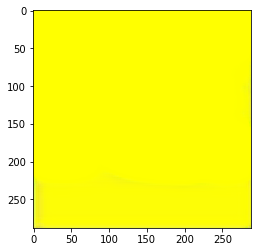

In [27]:
plt.imshow(p[0].astype('uint8'))